In [131]:
#import pip 
#pip.main(['install','surprise'])

In [1]:
import json
import pandas as pd
import os
import numpy as np
from nltk.corpus import stopwords
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import string
from nltk.stem.snowball import SnowballStemmer
from surprise import Reader, Dataset, SVD, evaluate
from sklearn.metrics import confusion_matrix
import random
pd.set_option('display.max_columns', 500)
from sklearn.metrics import pairwise_distances
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from surprise.model_selection import KFold
from surprise import KNNBasic
from surprise import Dataset
from surprise import accuracy

In [2]:
df=pd.read_csv('df_final.csv')
df_features=pd.read_csv('df_feature.csv')

In [3]:
df.head()

,business_id,name,avg_stars,address,longitude,latitude,review_id,stars,text,user_id
0,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,4.0,3355 Las Vegas Blvd S,-115.16919,36.123183,KEAHrqN-1DV0gmuNHM6Eww,5.0,As part of a birthday celebration weekend for ...,xP1IYu2eGfxMWV9tjrurIw
1,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,4.0,3355 Las Vegas Blvd S,-115.16919,36.123183,6SgvNWJltnZhW7duJgZ42w,5.0,This is mine and my fiancé's favorite steakhou...,oFyOUOeGTRZhFPF9uTqrTQ
2,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,4.0,3355 Las Vegas Blvd S,-115.16919,36.123183,iwx6s6yQxc7yjS7NFANZig,4.0,Nice atmosphere and wonderful service. I had t...,2aeNFntqY2QDZLADNo8iQQ
3,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,4.0,3355 Las Vegas Blvd S,-115.16919,36.123183,UVUMu_bELdA56Ryfbur-DA,5.0,Every year a group of us (we had 6 this year) ...,gmPP4YFrgYsYQqPYokMgFA
4,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,4.0,3355 Las Vegas Blvd S,-115.16919,36.123183,Jjz9W-wBkoBoMcB8ZQs5zQ,5.0,We had early reservations for a party of 9 for...,9bxdPvAhP6cuipD5s2UnCg


In [4]:
df_features.head()

,american,fast_food,mexican,chinese,italian,japanese,others,casual,classy,upscale,noise_level,business_id,happy_hour,latenight,brunch,dinner,lunch
0,1,0,0,0,0,0,0,1,0,0,2,Pd52CjgyEU3Rb8co6QfTPw,1,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,4,n7V4cD-KqqE3OXk0irJTyA,0,1,1,0,0
2,0,1,0,0,0,0,0,0,0,0,4,Wpt0sFHcPtV5MO9He7yMKQ,0,0,0,0,0
3,1,0,0,0,0,0,0,1,0,0,2,W1Yr6c2XDx_RBjb6WsV-aQ,1,0,0,0,1
4,1,0,0,0,0,0,0,1,0,0,2,Uy3_5nLo3sYkAuSX6mjdmg,0,1,0,0,1


In [5]:
len(df['business_id'].unique())

4727

There are 4727 restaurants in Las Vegas in Our dataset.

In [6]:
len(df['user_id'].unique())

336464

There are 336464 users in our dataset.

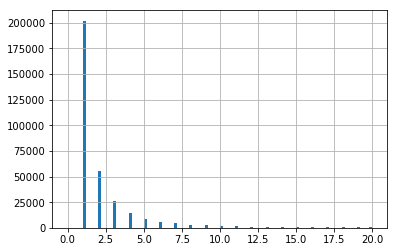

In [7]:
df['user_id'].value_counts().hist(bins = 100, range = (0,20))
plt.show()

Lots of users only write a few reviews. A few users write thousands of reviews.

Choose users with more than 10 reviews

In [8]:
re = df['user_id'].value_counts().index[df['user_id'].value_counts().values > 10]
df1=df[df['user_id'].isin(re.values)]
len(df1['user_id'].unique())

11641

There are 11641 users after filtering for 10 reviews.

In [9]:
df1['user_id'].value_counts().describe()

count    11641.000000
mean        25.456404
std         30.763093
min         11.000000
25%         13.000000
50%         17.000000
75%         26.000000
max       1143.000000
Name: user_id, dtype: float64

In [10]:
df_ratings = df1[['user_id', 'business_id', 'stars']] 
df_name = df1[['business_id','name']]
df_text = df1[['business_id','text']]
category=df_features[df_features['business_id'].isin(df1['business_id'].unique())]

In [11]:
df_ratings.head()

,user_id,business_id,stars
1,oFyOUOeGTRZhFPF9uTqrTQ,--9e1ONYQuAa-CB_Rrw7Tw,5.0
4,9bxdPvAhP6cuipD5s2UnCg,--9e1ONYQuAa-CB_Rrw7Tw,5.0
8,HmN7p502YMJGkBNv5bzi1w,--9e1ONYQuAa-CB_Rrw7Tw,5.0
9,3RTesI_MAwct13LWm4rhLw,--9e1ONYQuAa-CB_Rrw7Tw,4.0
10,4PIcs3X-Ro_KoczDJ3y4ZQ,--9e1ONYQuAa-CB_Rrw7Tw,5.0


In [12]:
df_ratings['stars'].mean()

3.7372088628525537

#### Evaluation
#### We use precision@k and recall@k to measure our models.
#### Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)
#### Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)


In [13]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls


# SVD

In [14]:
reader= Reader()
data = Dataset.load_from_df(df_ratings, reader)
svd = SVD()
kf = KFold(n_splits=5)
svd_train_precision = list()
svd_train_recall = list()
svd_test_recall = list()
svd_test_precision = list()

for i, (trainset_cv, testset_cv) in enumerate(kf.split(data)):
    print('fold number', i + 1)
    svd.fit(trainset_cv)

    print('On testset,', end='  ')
    predictions = svd.test(testset_cv)
    accuracy.rmse(predictions, verbose=True)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    svd_test_precision.append(sum(prec for prec in precisions.values()) / len(precisions))
    svd_test_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
    print('Precision:',sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall:',sum(rec for rec in recalls.values()) / len(recalls))


    print('On trainset,', end=' ')
    predictions = svd.test(trainset_cv.build_testset())
    accuracy.rmse(predictions, verbose=True)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    svd_train_precision.append(sum(prec for prec in precisions.values()) / len(precisions))
    svd_train_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
    print('Precision:',sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall:',sum(rec for rec in recalls.values()) / len(recalls))


fold number 1
On testset,  RMSE: 1.0831
Precision: 0.7718971631205801
Recall: 0.738830609026899
On trainset, RMSE: 0.7684
Precision: 0.9591787647109206
Recall: 0.501943678934592
fold number 2
On testset,  RMSE: 1.0840
Precision: 0.7740850950435376
Recall: 0.7421331260071131
On trainset, RMSE: 0.7673
Precision: 0.9588981473527345
Recall: 0.5019723585432083
fold number 3
On testset,  RMSE: 1.0824
Precision: 0.7791255811199084
Recall: 0.738232322427144
On trainset, RMSE: 0.7694
Precision: 0.9574936288405806
Recall: 0.49996126342732156
fold number 4
On testset,  RMSE: 1.0805
Precision: 0.7752410957283287
Recall: 0.743759365006783
On trainset, RMSE: 0.7680
Precision: 0.9591315179108189
Recall: 0.5010308504276293
fold number 5
On testset,  RMSE: 1.0782
Precision: 0.7752541418452471
Recall: 0.7416871549827395
On trainset, RMSE: 0.7689
Precision: 0.9590098216075249
Recall: 0.5003875440578597


In [15]:
np.mean(svd_test_recall)

0.7409285154901356

In [16]:
np.mean(svd_test_precision)

0.7751206153715203

In [17]:
df_ratings[df_ratings['user_id']=="-go-R_jzvYLYngQbfKN4_A"]

,user_id,business_id,stars
44003,-go-R_jzvYLYngQbfKN4_A,2XkVexeY_8zyc9nriSElQg,4.0
60060,-go-R_jzvYLYngQbfKN4_A,3IwCop28R1_L5jMv6AkL8Q,5.0
140916,-go-R_jzvYLYngQbfKN4_A,9XelmxS5q9tv7uClvjGqMg,4.0
143867,-go-R_jzvYLYngQbfKN4_A,9qcTpWYxrZrN13p1zAP6dA,4.0
167783,-go-R_jzvYLYngQbfKN4_A,BjS35X3-_-9TP-RyfzoC_Q,2.0
175601,-go-R_jzvYLYngQbfKN4_A,CSaVK9wgqe2_tQuuCDINyQ,3.0
227016,-go-R_jzvYLYngQbfKN4_A,F5BCXUpQpCRPeFmWnQmSJA,5.0
292263,-go-R_jzvYLYngQbfKN4_A,JKTMgelIQ-VHn7SL5nyiWA,5.0
386403,-go-R_jzvYLYngQbfKN4_A,PM0A7ZgbxvtbRCj931PbyQ,5.0
408701,-go-R_jzvYLYngQbfKN4_A,Ql0iiHl2xpIwtkuC255Wiw,3.0


In [18]:
example = df_ratings[df_ratings['user_id']=="-go-R_jzvYLYngQbfKN4_A"]
pre = list()
for i in range(len(example)):
    pre.append(svd.predict('-go-R_jzvYLYngQbfKN4_A',example['business_id'].iloc[i])[3])

In [19]:
b=pd.DataFrame(np.concatenate((example,pd.DataFrame(pre)),axis=1))
b.columns= ['user_id','business_id','actual','predict']
b.head()

,user_id,business_id,actual,predict
0,-go-R_jzvYLYngQbfKN4_A,2XkVexeY_8zyc9nriSElQg,4,4.35074
1,-go-R_jzvYLYngQbfKN4_A,3IwCop28R1_L5jMv6AkL8Q,5,4.3832
2,-go-R_jzvYLYngQbfKN4_A,9XelmxS5q9tv7uClvjGqMg,4,4.07368
3,-go-R_jzvYLYngQbfKN4_A,9qcTpWYxrZrN13p1zAP6dA,4,3.94176
4,-go-R_jzvYLYngQbfKN4_A,BjS35X3-_-9TP-RyfzoC_Q,2,3.45975


In [20]:
b['relevant'] = 0 
b['relevant'][b['actual']>3.5] =1

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
b['recommend'] = 0 
b['recommend'][b['predict']>3.5] =1

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
b.head()

,user_id,business_id,actual,predict,relevant,recommend
0,-go-R_jzvYLYngQbfKN4_A,2XkVexeY_8zyc9nriSElQg,4,4.35074,1,1
1,-go-R_jzvYLYngQbfKN4_A,3IwCop28R1_L5jMv6AkL8Q,5,4.3832,1,1
2,-go-R_jzvYLYngQbfKN4_A,9XelmxS5q9tv7uClvjGqMg,4,4.07368,1,1
3,-go-R_jzvYLYngQbfKN4_A,9qcTpWYxrZrN13p1zAP6dA,4,3.94176,1,1
4,-go-R_jzvYLYngQbfKN4_A,BjS35X3-_-9TP-RyfzoC_Q,2,3.45975,0,0


In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
cm = confusion_matrix(b['relevant'], b['recommend'], labels = [1,0])
cm_df = pd.DataFrame(cm, columns = ['Recommend', 'Not Recommend'])
cm_df.index = ['Relevant','Not Relevant']
cm_df

,Recommend,Not Recommend
Relevant,16,1
Not Relevant,2,4


# item-item

In [25]:
sim_options = {'name': 'cosine',
               'user_based': False  # compute similarities between items
               }
algo = KNNBasic(sim_options=sim_options)
kf = KFold(n_splits=5)
ii_train_precision = list()
ii_train_recall = list()
ii_test_recall = list()
ii_test_precision = list()

for i, (trainset_cv, testset_cv) in enumerate(kf.split(data)):
    print('fold number', i + 1)
    algo.fit(trainset_cv)

    print('On testset,', end='  ')
    predictions = algo.test(testset_cv)
    accuracy.rmse(predictions, verbose=True)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    ii_test_precision.append(sum(prec for prec in precisions.values()) / len(precisions))
    ii_test_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
 
    print('Precision:',sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall:',sum(rec for rec in recalls.values()) / len(recalls))


    print('On trainset,', end=' ')
    predictions = algo.test(trainset_cv.build_testset())
    accuracy.rmse(predictions, verbose=True)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    ii_train_precision.append(sum(prec for prec in precisions.values()) / len(precisions))
    ii_train_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
    print('Precision:',sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall:',sum(rec for rec in recalls.values()) / len(recalls))


fold number 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1745
Precision: 0.742588318835449
Recall: 0.6966127340323118
On trainset, RMSE: 1.0483
Precision: 0.9507874466683756
Recall: 0.3400096550151158
fold number 2
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1589
Precision: 0.7545737122557858
Recall: 0.6963951968293894
On trainset, RMSE: 1.0510
Precision: 0.9507659708501444
Recall: 0.3407919600704886
fold number 3
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1662
Precision: 0.7558129215477578
Recall: 0.6877391716658441
On trainset, RMSE: 1.0495
Precision: 0.9516879993127637
Recall: 0.3376438761018279
fold number 4
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1651
Precision: 0.7472395184724091
Recall: 0.6921456449327419
On trainset, RMSE: 1.0506
Precision: 0.9520273172407779
Reca

In [26]:
np.mean(ii_test_recall)

0.6927404761922527

In [27]:
np.mean(ii_test_precision)

0.750557532764042

In [29]:
example = df_ratings[df_ratings['user_id']=="X5A_vtJh_PTQgQ5pmluCqg"]
pre = list()
for i in range(len(example)):
    pre.append(algo.predict('X5A_vtJh_PTQgQ5pmluCqg',example['business_id'].iloc[i])[3])

c=pd.DataFrame(np.concatenate((example,pd.DataFrame(pre)),axis=1))
c.columns= ['user_id','business_id','actual','predict']
c.head()

,user_id,business_id,actual,predict
0,X5A_vtJh_PTQgQ5pmluCqg,3IwCop28R1_L5jMv6AkL8Q,5,3.69821
1,X5A_vtJh_PTQgQ5pmluCqg,3LWsVfsSmb_Nzbi2YQ-NIA,4,3.8704
2,X5A_vtJh_PTQgQ5pmluCqg,7vHvQCjPq5pWj7Rio1A--w,5,3.65456
3,X5A_vtJh_PTQgQ5pmluCqg,FSnqO-YWUdRb0Xc95nXbvw,5,3.65833
4,X5A_vtJh_PTQgQ5pmluCqg,O-04UXVtgezKPiQJOll3hg,3,3.65099


In [31]:
c['relevant'] = 0 
c['relevant'][c['actual']>3.5] =1
c['recommend'] = 0 
c['recommend'][c['predict']>3.5] =1
c.head()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,user_id,business_id,actual,predict,relevant,recommend
0,X5A_vtJh_PTQgQ5pmluCqg,3IwCop28R1_L5jMv6AkL8Q,5,3.69821,1,1
1,X5A_vtJh_PTQgQ5pmluCqg,3LWsVfsSmb_Nzbi2YQ-NIA,4,3.8704,1,1
2,X5A_vtJh_PTQgQ5pmluCqg,7vHvQCjPq5pWj7Rio1A--w,5,3.65456,1,1
3,X5A_vtJh_PTQgQ5pmluCqg,FSnqO-YWUdRb0Xc95nXbvw,5,3.65833,1,1
4,X5A_vtJh_PTQgQ5pmluCqg,O-04UXVtgezKPiQJOll3hg,3,3.65099,0,1


In [32]:
#Confusion Matrix
cm = confusion_matrix(c['relevant'], c['recommend'], labels = [1,0])
cm_df = pd.DataFrame(cm, columns = ['Recommend', 'Not Recommend'])
cm_df.index = ['Relevant','Not Relevant']
cm_df

,Recommend,Not Recommend
Relevant,7,0
Not Relevant,4,0


# User-User

In [33]:
reader= Reader()
data = Dataset.load_from_df(df_ratings, reader)
sim_options = {'name': 'cosine',
               'user_based': True  # compute  similarities between users
               }
algo = KNNBasic(sim_options=sim_options)
kf = KFold(n_splits=5)
uu_train_precision = list()
uu_train_recall = list()
uu_test_recall = list()
uu_test_precision = list()

for i, (trainset_cv, testset_cv) in enumerate(kf.split(data)):
    print('fold number', i + 1)
    algo.fit(trainset_cv)

    print('On testset,', end='  ')
    predictions = algo.test(testset_cv)
    accuracy.rmse(predictions, verbose=True)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    uu_test_precision.append(sum(prec for prec in precisions.values()) / len(precisions))
    uu_test_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
    print('Precision:',sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall:',sum(rec for rec in recalls.values()) / len(recalls))


    print('On trainset,', end=' ')
    predictions = algo.test(trainset_cv.build_testset())
    accuracy.rmse(predictions, verbose=True)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)
    uu_train_precision.append(sum(prec for prec in precisions.values()) / len(precisions))
    uu_train_recall.append(sum(rec for rec in recalls.values()) / len(recalls))
    print('Precision:',sum(prec for prec in precisions.values()) / len(precisions))
    print('Recall:',sum(rec for rec in recalls.values()) / len(recalls))



fold number 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1400
Precision: 0.745462765326703
Recall: 0.7579528786661575
On trainset, RMSE: 1.0657
Precision: 0.8199295593162308
Recall: 0.4469824554057165
fold number 2
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1416
Precision: 0.750836590855259
Recall: 0.7563885799925522
On trainset, RMSE: 1.0646
Precision: 0.8184577499069582
Recall: 0.445765412443959
fold number 3
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1445
Precision: 0.7497001654259835
Recall: 0.7534888151047041
On trainset, RMSE: 1.0642
Precision: 0.8192251524783266
Recall: 0.4471463200452293
fold number 4
Computing the cosine similarity matrix...
Done computing similarity matrix.
On testset,  RMSE: 1.1466
Precision: 0.7456945308104687
Recall: 0.7500126264233562
On trainset, RMSE: 1.0638
Precision: 0.8205724021418724
Recall

In [34]:
np.mean(uu_test_recall)

0.7540845298899523

In [35]:
np.mean(uu_test_precision)

0.7484581958264747

In [36]:
example = df_ratings[df_ratings['user_id']=="X5A_vtJh_PTQgQ5pmluCqg"]
pre = list()
for i in range(len(example)):
    pre.append(algo.predict('X5A_vtJh_PTQgQ5pmluCqg',example['business_id'].iloc[i])[3])

d=pd.DataFrame(np.concatenate((example,pd.DataFrame(pre)),axis=1))
d.columns= ['user_id','business_id','actual','predict']
d.head()

,user_id,business_id,actual,predict
0,X5A_vtJh_PTQgQ5pmluCqg,3IwCop28R1_L5jMv6AkL8Q,5,3.775
1,X5A_vtJh_PTQgQ5pmluCqg,3LWsVfsSmb_Nzbi2YQ-NIA,4,4.275
2,X5A_vtJh_PTQgQ5pmluCqg,7vHvQCjPq5pWj7Rio1A--w,5,3.825
3,X5A_vtJh_PTQgQ5pmluCqg,FSnqO-YWUdRb0Xc95nXbvw,5,3.7
4,X5A_vtJh_PTQgQ5pmluCqg,O-04UXVtgezKPiQJOll3hg,3,4.23822


In [37]:
d['relevant'] = 0 
d['relevant'][d['actual']>3.5] =1
d['recommend'] = 0 
d['recommend'][d['predict']>3.5] =1
d.head()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,user_id,business_id,actual,predict,relevant,recommend
0,X5A_vtJh_PTQgQ5pmluCqg,3IwCop28R1_L5jMv6AkL8Q,5,3.775,1,1
1,X5A_vtJh_PTQgQ5pmluCqg,3LWsVfsSmb_Nzbi2YQ-NIA,4,4.275,1,1
2,X5A_vtJh_PTQgQ5pmluCqg,7vHvQCjPq5pWj7Rio1A--w,5,3.825,1,1
3,X5A_vtJh_PTQgQ5pmluCqg,FSnqO-YWUdRb0Xc95nXbvw,5,3.7,1,1
4,X5A_vtJh_PTQgQ5pmluCqg,O-04UXVtgezKPiQJOll3hg,3,4.23822,0,1


In [38]:
cm = confusion_matrix(d['relevant'], d['recommend'], labels = [1,0])
cm_df = pd.DataFrame(cm, columns = ['Recommend', 'Not Recommend'])
cm_df.index = ['Relevant','Not Relevant']
cm_df

,Recommend,Not Recommend
Relevant,7,0
Not Relevant,3,1


# Content Based

In [40]:
df_t=pd.read_csv('df_text.csv')

In [41]:
def get_text(df):
    df_tf=df_t.groupby('business_id').sum()
    return df_tf

df_tf = get_text(df_t)

In [42]:
def get_wordstemming(df_tf):
    df_tf_1 = df_tf['text']
    df_tf_1=df_tf_1.str.split()
    df_tf_1 = pd.DataFrame(df_tf_1)
    df_tf_1.columns =["keywords"]
    stemmer = SnowballStemmer('english')
    df_tf_1['keywords'] = df_tf_1['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
    df_tf_1['keywords'] = df_tf_1['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
    df_tf_1['keywords'] = df_tf_1['keywords'].apply(lambda x: ' '.join(x))
    return df_tf_1

df_tf_1=get_wordstemming(df_tf)

In [43]:
def get_cosinesim(df_tf_1):
    stopwords_list = stopwords.words('english') + list(string.punctuation)
    vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)
    item_ids = df_ratings['business_id'].tolist()
    tfidf_matrix = vectorizer.fit_transform(df_tf_1['keywords'])
    tfidf_feature_names = vectorizer.get_feature_names()
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    return cosine_sim

In [ ]:
cosine_sim = get_cosinesim(df_tf_1)

In [ ]:
def get_recommendations(title):
    #df.iloc[np.where(df['name'] == title)[0][0],:]['business_id'] 
    #smd = df_tf.reset_index()
    #titles = smd['business_id']
    title=df[df['name'] == title]['business_id'].unique()[0]
    titles=df['business_id'].unique()
    
    indices = pd.Series(df.index[:len(titles)], index=titles)
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:151]
    restaurant_indices = [i[0] for i in sim_scores]
    result=titles[restaurant_indices]
    result1=df[df['business_id'].isin(result)]['name'].unique().tolist()
    return result1

In [ ]:
get_recommendations('Delmonico Steakhouse')

# Hybrid

In [ ]:
def hybrid(userId, title):
    businessid = df.iloc[np.where(df['name'] == title)[0],:]["business_id"].unique()[0]
    idx=np.where(pd.DataFrame(list(enumerate(df['business_id'].unique())))[1] == businessid)[0]

    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    restaurant_indices = [i[0] for i in sim_scores]
    restaurant_id = df['business_id'].unique()[restaurant_indices]
    df[df['business_id'].isin(restaurant_id)]['name'].unique().tolist()

    scores= np.zeros(restaurant_id.shape[0])
    for i in range(restaurant_id.shape[0]):
        scores[i]= svd.predict(userId,restaurant_id[i]).est
    result= pd.DataFrame(np.hstack((pd.DataFrame(restaurant_id),    pd.DataFrame(scores))))    
    result.columns = ['business_id','scores']
    
    final=result.sort_values('scores',ascending=False)
   
    return(df[df['business_id'].isin(final["business_id"])]['name'].unique().tolist())


In [ ]:
hybrid('L8cvMZLWmM4qWTl9SkxJ8g','Delmonico Steakhouse')